# Interpreting a Random Forest Model with LIME
### A Demonstration for Federal Government AI Professionals

In this notebook, we will:
1. Install and import [**LIME**](https://github.com/marcotcr/lime), a popular library for model interpretability.
2. Load the **Boston Housing** dataset from a **new URL**.
3. Train a **Random Forest** regressor to predict housing prices.
4. Use **LIME** to explain the predictions of specific instances.

> **Why it matters**: Federal agencies often require interpretable models to ensure fairness, transparency, and accountability in decision-making processes. Whether you’re working on a housing grants project or any other high-stakes federal program, LIME can help you provide clear explanations to policymakers and stakeholders.

## 1. Install LIME (if needed)

In [1]:
!pip install lime --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## 2. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import requests

# Sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# LIME
from lime.lime_tabular import LimeTabularExplainer

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

## 3. Load the Dataset

We'll pull the Boston Housing dataset from GitHub (hosted by [Selva Prabhakaran](https://github.com/selva86/datasets/)).

> **Note**: The original code attempted to load a `.pkl` file from a URL that’s no longer valid. Here, we’ve switched to a CSV-based version of the dataset for simplicity.

In [3]:
# New URL for the Boston Housing CSV
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'

# Fetch the data
response = requests.get(url)
data_as_string = response.content.decode('utf-8')

# Read into a pandas DataFrame
housing_df = pd.read_csv(pd.io.common.StringIO(data_as_string))

print("Data loaded successfully!")
housing_df.head()

Data loaded successfully!


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Quick Data Exploration

In [4]:
# Summary stats
housing_df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## 4. Define Features and Target

The dataset columns:
- `medv` is the median home value (our **target**).
- All other columns are **features**.

For this demo, we use all features, but in a real Federal agency scenario, you might select features aligned with policy or domain constraints (e.g., focusing on geospatial, demographic, or environmental attributes).

In [5]:
# Separate features (X) and target (y)
X = housing_df.drop('medv', axis=1)
y = housing_df['medv']

# We will store feature names for LIME
feature_names = X.columns.tolist()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (404, 13)
Test set size: (102, 13)


## 5. Train a Random Forest Model

Random Forest is a popular ensemble method that often works well out-of-the-box. After training, we can interpret individual predictions using LIME.

In [6]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print(f"Random Forest Training R^2 Score: {train_score:.3f}")
print(f"Random Forest Test R^2 Score: {test_score:.3f}")

Random Forest Training R^2 Score: 0.977
Random Forest Test R^2 Score: 0.893


## 6. Interpreting Predictions with LIME

[**LIME**](https://github.com/marcotcr/lime) stands for **Local Interpretable Model-agnostic Explanations**. It explains individual predictions by approximating the complex model locally (near the instance you want to explain) with a simpler model (like a linear model).

### Defining Categorical Features
In some Federal use-cases, you may have a mix of numeric and categorical data. For demonstration, let’s assume `chas` (Charles River dummy variable) is categorical:
- `chas` = 1 if the property bounds the river; 0 otherwise.

In the Boston dataset, that’s the 4th column (0-indexed = 3).

In [7]:
# Let's identify categorical columns for LIME
cat_cols = [3]  # 'chas' column

explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    categorical_features=cat_cols,
    mode='regression'
)
print("LIME explainer initialized!")

LIME explainer initialized!


### 6.1 Explain a Single Instance
We will select an instance (say, index=10 in our test set) and explain the Random Forest’s predicted price.

/usr/local/lib/python3.9/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.9/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.9/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

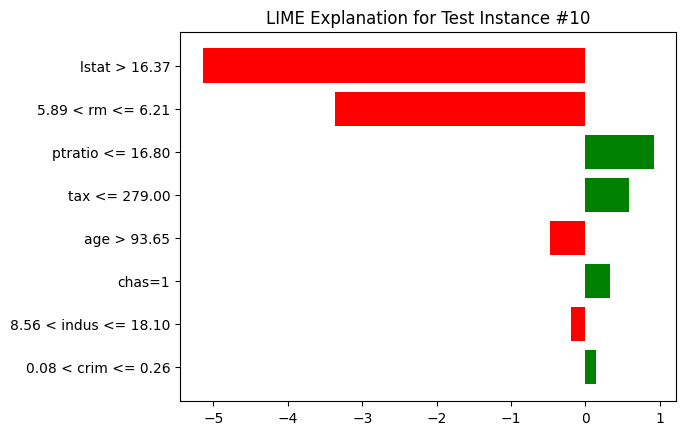


Explanation as list of (feature, effect):
lstat > 16.37 => -5.146
5.89 < rm <= 6.21 => -3.372
ptratio <= 16.80 => 0.915
tax <= 279.00 => 0.579
age > 93.65 => -0.481
chas=1 => 0.336
8.56 < indus <= 18.10 => -0.198
0.08 < crim <= 0.26 => 0.144


In [8]:
instance_idx = 10  # pick an index from the test set

exp = explainer.explain_instance(
    data_row=X_test.iloc[instance_idx],
    predict_fn=regressor.predict,
    num_features=8
)

fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Test Instance #{instance_idx}")
plt.show()

exp_list = exp.as_list()
print("\nExplanation as list of (feature, effect):")
for feature, val in exp_list:
    print(f"{feature} => {val:.3f}")

### 6.2 Compare Explanations for Multiple Instances
For a better understanding, let’s compare explanations for two more instances.

/usr/local/lib/python3.9/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.9/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.9/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

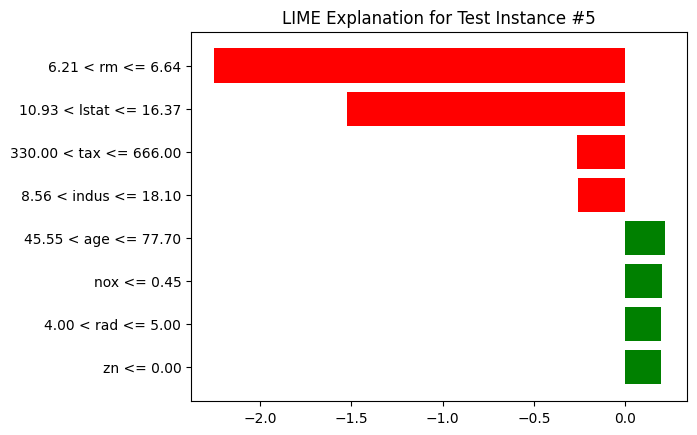

/usr/local/lib/python3.9/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.9/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.9/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

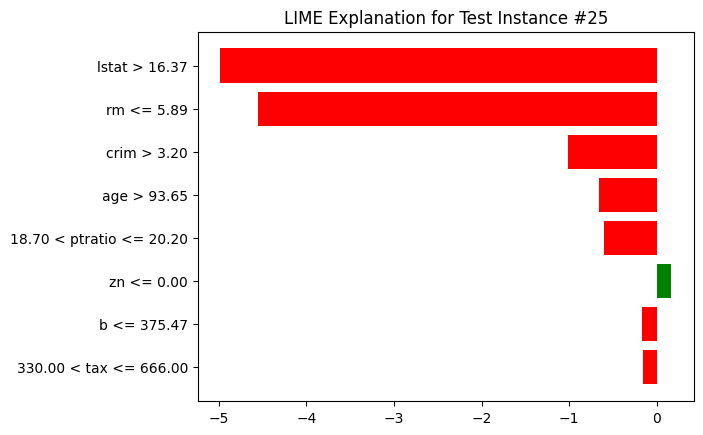

In [9]:
instances_to_explain = [5, 25]  # you can pick any two test indices

for i in instances_to_explain:
    exp = explainer.explain_instance(
        data_row=X_test.iloc[i],
        predict_fn=regressor.predict,
        num_features=8
    )
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for Test Instance #{i}")
    plt.show()

## Conclusion

You have just seen how **LIME** can help Federal Government AI professionals—and really anyone—explain the predictions of complex models, such as **Random Forest** in this example.

In a real-world Federal use-case, such transparency is often required for:
- **Policy compliance** (e.g., ensuring no unlawful biases).
- **Audit and oversight** by internal or external agencies.
- **Stakeholder communication** with leadership and the public.

Experiment with different rows, features, and model parameters to see how explanations change. This will help build trust and confidence in your machine learning solutions!